This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

The train6 files were used to determine the cause of the memory leak which seems to have been using multiple workers which causes copy-on-reads to occur. setting num_wokers=0 in the dataloader resolves this issue.
See issue: https://github.com/pytorch/pytorch/issues/13246#issuecomment-905703662
blogpost: https://ppwwyyxx.com/blog/2022/Demystify-RAM-Usage-in-Multiprocess-DataLoader/

The train7 files started using datasets processed by huggingface libraries. This file continues from there.

In [1]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_30M_small_emb = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 18,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [5]:
GPT_CONFIG_120M_DEEP = {
    "vocab_size": vocab_size,
    "context_length": 512, # this must be multiple of 64 for the flash attention implementation
    "emb_dim": 512, # this must be multiple of 16 * n_heads for the flash attention implementation
    "n_heads": 32,
    "n_layers": 21,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [6]:
GPT_CONFIG_120M_SHALLOW = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 24,
    "n_layers": 10,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [7]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_120M_DEEP

In [8]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [9]:
trainer_config = {
    "dataset_scale": 1,
    "batch_size": 32 if "laptop" in hostname else 8,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 0,
    "max_lr": 1e-3,
    "compile": "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [10]:
from components.gptmodel import GPTModel_GeGLU
from torch.optim.lr_scheduler import OneCycleLR
import lightning as L
from datasets import load_from_disk
from torch.utils.data import DataLoader


class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1

        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]
        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]

        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        self.packed_dataset = load_from_disk("packed_dataset_with_mask")
        self.packed_dataset.set_format('torch')

        self.model = GPTModel_GeGLU(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)

    def train_dataloader(self):
        return DataLoader(self.packed_dataset["train"], batch_size=self.trainer_config["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.packed_dataset["validation"], batch_size=self.trainer_config["batch_size"], shuffle=False)


/home/gebrial/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [12]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    # callbacks=[
    #     L.callbacks.LearningRateMonitor(logging_interval="step"),
    #     L.callbacks.ModelCheckpoint(
    #         monitor="val_loss",
    #         mode="min",
    #         save_top_k=1,
    #         filename="{epoch:02d}-{val_loss:.2f}",
    #         dirpath="./checkpoints/120M_DEEP/"
    #     )
    # ],
    precision="bf16-mixed" #"bf16-mixed", # or "transformer-engine" for 8-bit mixed
)
trainer.fit(model=litmodel)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/gebrial/projects/llm-from-scr

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 117818/117818 [3:24:41<00:00,  9.59it/s, accuracy_step=0.649, loss_step=1.320, val_accuracy_step=0.896, val_loss_step=0.445, val_accuracy_epoch=0.664, val_loss_epoch=1.260, accuracy_epoch=0.569, loss_epoch=1.960]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 117818/117818 [3:24:43<00:00,  9.59it/s, accuracy_step=0.649, loss_step=1.320, val_accuracy_step=0.896, val_loss_step=0.445, val_accuracy_epoch=0.664, val_loss_epoch=1.260, accuracy_epoch=0.569, loss_epoch=1.960]
CPU times: user 6h 19min 23s, sys: 12min 13s, total: 6h 31min 36s
Wall time: 3h 24min 56s


In [ ]:
trainer.save_checkpoint(
    "./checkpoints/120M_DEEP_bf16_geglu_one_epoch.ckpt",
)

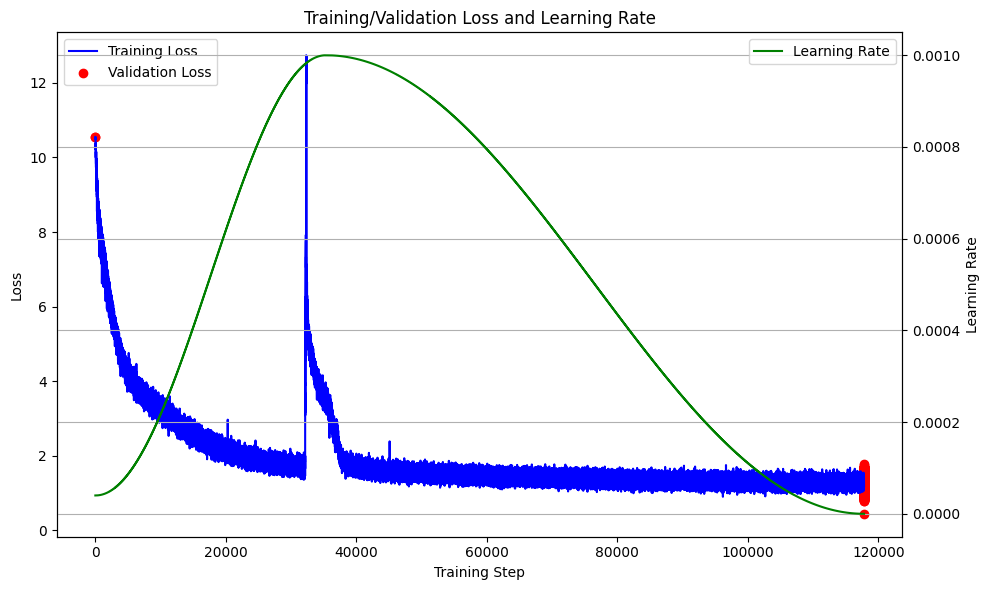

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

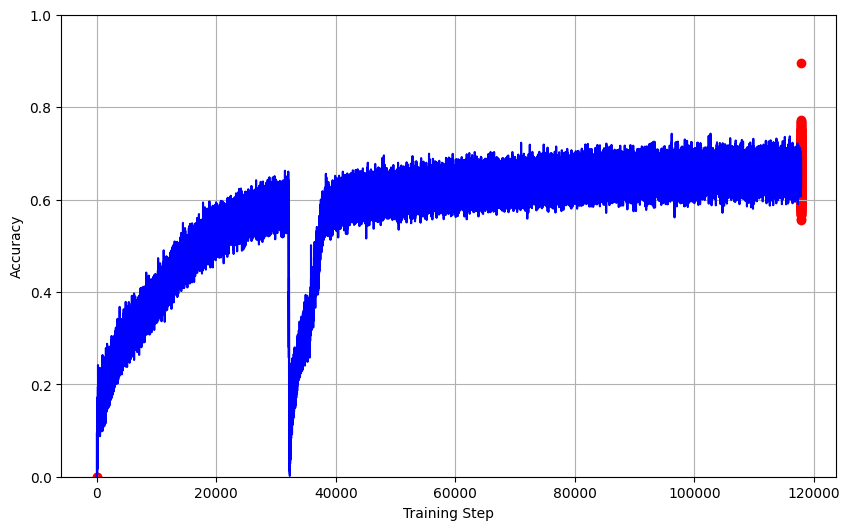

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [16]:
from tokenizers import Tokenizer

In [17]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [18]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): GPTModel_GeGLU(
    (tok_emb): Embedding(30002, 512)
    (pos_emb): Embedding(512, 512)
    (drop_emb): Dropout(p=0.1, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock_GeGLU(
        (att): MultiHeadAttention_v3(
          (W_query): Linear(in_features=512, out_features=512, bias=False)
          (W_key): Linear(in_features=512, out_features=512, bias=False)
          (W_value): Linear(in_features=512, out_features=512, bias=False)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForwardGeGLU(
          (net): Sequential(
            (0): GeGLU(
              (proj): Linear(in_features=512, out_features=4096, bias=True)
            )
            (1): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (drop

In [20]:
sum([p.numel() for p in litmodel.model.parameters() if p.requires_grad])

119216128

In [21]:
from components.generatetext import generate_text_with_attn

In [23]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x7f7ea80f42c0>
Traceback (most recent call last):
  File "/home/gebrial/miniforge3/lib/python3.12/site-packages/torch/_dynamo/utils.py", line 589, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))

KeyboardInterrupt: 


text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not ready yet! She says " Oh no! I made too much mess. Can we have something more to make more?" But Tom says " No! We can ' ve some more tea and cookies. That ' re a nice thing to have ". They go and look around for something to eat and cookies instead. Jane says, ' Thank goodness Tom, this is much better!' They both laugh and enjoy their tea.
CPU times: user 23.8 s, sys: 3.64 s, total: 27.4 s
Wall time: 27.5 s


In [25]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is too spicy! Jane ' mom is not happy with her soup. She scolds Jane for wasting her time and not sharing. Jane feels sad. Tom is not glad that he was wrong, so Jane tells Tom to be a better friend and share his food too. They talk and talk until Jane ' s dad comes home from school. He has some extra spicy food. He puts it in his pot of spicy sauce and adds some spices and salt. Jane is surprised and smiles. She likes the soup and the soup. She thanks her dad for sharing. Tom and his mom are happy that Tom learned his importance of being a kind friend. They both have fun playing and eating soup. The end.
CPU times: user 768 ms, sys: 59.6 ms, total:

In [ ]:
import csv
import time

with open('evaluation_prompts.csv', mode='r') as file:
    csv_reader = csv.DictReader(file)
    data = [row for row in csv_reader]  # Each row is a dictionary

data_len = len(data)
current_index = 0
# measure time
start_time = time.time()
# Modify data (e.g., change 'age' column to integers)
for row in data:
    current_index += 1
    starting_text = row['prompt']
    output_text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1, output_only=True)
    row['completion'] = output_text
    if current_index % 10 == 0:
        # print prompt
        print(f"Prompt {current_index}: {starting_text}")
        # print output
        print(f"Row {current_index}: {output_text}")
        current_time = time.time()
        elapsed_time = current_time - start_time
        time_left = (data_len - current_index) * (elapsed_time / current_index)
        print(f"Processed {current_index}/{data_len} rows. Estimated time left: {time_left:.2f} seconds.")


In [ ]:
with open('evaluation_outputs.csv', mode='w', newline='') as file:
    fieldnames = data[0].keys()  # Get column names
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(data)